In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from basin_volume import *

/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

## Model-specific setup

In [4]:
# we can set mesa_constrain=True and norm_scale=(float) to clamp the norm of the parameters
# instead, we'll add an L2 penalty to the loss function here:
cfg = MLPTrainConfig(train_size=1024, 
                     opt="adam", 
                     lr=.05,
                     l2_reg=5e-4,
                    )

In [14]:
# Train the model
# This needs a refactor -- all the messiness is hiding in training.py
# You don't need to worry about it to use this package with other models

final_params, state, apply_fn, X_train, Y_train, model = train_mlp(cfg)

In [6]:
kl_fn = make_kl_fn_params(final_params.raveled, apply_fn, X_train, l2_reg=0.)

In [7]:
H = jax.hessian(kl_fn, argnums=0)(final_params.raveled, 0)

In [8]:
adam_state, _, schedule_state = state.opt_state
mu, nu = adam_state.mu['p'], adam_state.nu['p']

# standard deviation of the Gaussian we'll use to weight our estimates
sigma_epoch = 1/jnp.sqrt(cfg.l2_reg * cfg.train_size)

## HesScale

In [ ]:
def loss_fn_perturbed(params, perturbations, x, y):
    logits, intermediates = model.apply({'params': params, 'perturbations': perturbations}, x, capture_intermediates=True)
    
    loss = sparse_xent(logits, y)
    acts = intermediates['intermediates']

    return loss, acts

In [ ]:
def gelu_prime(x):
    return jax.grad(jax.nn.gelu)(x)

def gelu_prime2(x):
    return jax.grad(gelu_prime)(x)


def gelu_prime_vec(x):
    return jax.vmap(gelu_prime)(x.reshape(-1)).reshape(x.shape)

def gelu_prime2_vec(x):
    return jax.vmap(gelu_prime2)(x.reshape(-1)).reshape(x.shape)


In [ ]:
def hesscale(params_unraveled):

    params = params_unraveled['params']

    variables = model.init(jax.random.key(0), X_train[0])
    params_new = variables['params'] # for later
    perturbations = variables['perturbations']
    grads, acts = jax.jacfwd(loss_fn_perturbed, argnums=1, has_aux=True)(params, perturbations, X_train, Y_train)

    d2_ker_est = {}
    d2_bias_est = {}
    d2_act_est = {}

    # second layer

    # [b, d]
    a_0 = acts['Dense_0']['__call__'][0]
    h_0 = jax.nn.gelu(a_0)

    # [b, 10]
    a_1 = acts['Dense_1']['__call__'][0]
    logits = a_1

    # [d, d]
    ker_0 = params['Dense_0']['kernel']

    # [d, 10]
    ker_1 = params['Dense_1']['kernel']

    # [b, 10]
    probs = jax.nn.softmax(logits, axis=-1)

    # [b, 10]
    d2_act_est[1] = probs - probs**2

    # [d, 10]
    d2_ker_est[1] = jnp.einsum('bi,bj,bj->ji',
                            d2_act_est[1],
                            h_0,
                            h_0) / h_0.shape[0]

    # [10]
    d2_bias_est[1] = d2_act_est[1].mean(axis=0)


    # first layer

    # [b, d]
    gelu_prime_a_0 = gelu_prime_vec(a_0)
    gelu_prime2_a_0 = gelu_prime2_vec(a_0)

    # [b, d]
    d2_act_est[0] = jnp.einsum(
        'bi,bi,bj,ij,ij->bi',
        gelu_prime_a_0,
        gelu_prime_a_0,
        d2_act_est[1],
        ker_1,
        ker_1
    ) + jnp.einsum(
        'bi,bj,ij->bi',
        gelu_prime2_a_0,
        grads['a_L'],
        ker_1
    )

    # [d, d]
    d2_ker_est[0] = jnp.einsum('bi,bj,bj->ji', 
                            d2_act_est[0],
                            X_train,
                            X_train) / X_train.shape[0]

    # [d]
    d2_bias_est[0] = d2_act_est[0].mean(axis=0)

    estimates = params_new
    estimates['Dense_0']['kernel'] = d2_ker_est[0]
    estimates['Dense_0']['bias'] = d2_bias_est[0]
    estimates['Dense_1']['kernel'] = d2_ker_est[1]
    estimates['Dense_1']['bias'] = d2_bias_est[1]

    return estimates


In [19]:
est = hesscale(final_params.unraveled)
diagH_hesscale = Raveler(est).raveled

In [79]:
diagH_hesscale.shape


(4810,)

## Volume estimation

In [20]:
CUTOFF = 1e-2

RESULTS = {}

In [21]:
RESULTS['naive'] = get_estimates_vectorized_gauss(10_000, 
                                                  sigma=sigma_epoch,
                                                  fn=kl_fn, 
                                                  params=final_params.raveled, 
                                                  cutoff=CUTOFF)


In [60]:
epsilons = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

In [61]:
best_epsilons = {}

In [62]:
#P = matrix_preconditioner(H, eps=1.3e-2, exponent=0.15)
maxes = {}
for epsilon in epsilons:
    P = matrix_preconditioner(H, eps=epsilon, exponent=0.5)
    RESULTS[f'hessian_{epsilon}'] = get_estimates_vectorized_gauss(3000, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P, 
                                                    fn=kl_fn, 
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF)
    maxes[epsilon] = RESULTS[f'hessian_{epsilon}'].estimates.max()
    print(f'epsilon: {epsilon}, max: {maxes[epsilon]}')
best_epsilons['hessian'] = max(maxes, key=maxes.get)

epsilon: 10.0, max: -9469.4169921875
epsilon: 1.0, max: -9451.6572265625
epsilon: 0.1, max: -9381.49609375
epsilon: 0.01, max: -9489.9111328125
epsilon: 0.001, max: -10573.54296875
epsilon: 0.0001, max: -13614.54296875
epsilon: 1e-05, max: -19023.87109375


In [65]:
#P_diagH = diag_preconditioner(jnp.diag(H), eps=8e-4, exponent=0.73)
maxes = {}
for epsilon in epsilons:
    P_diagH = diag_preconditioner(jnp.diag(H), eps=epsilon, exponent=0.5)
    RESULTS[f'diagH_{epsilon}'] = get_estimates_vectorized_gauss(3000, 
                                                  sigma=sigma_epoch,
                                                  preconditioner=P_diagH, 
                                                  fn=kl_fn, 
                                                  tol=1,
                                                  y_tol=10,
                                                  params=final_params.raveled, 
                                                  cutoff=CUTOFF)
    maxes[epsilon] = RESULTS[f'diagH_{epsilon}'].estimates.max()
    print(f'epsilon: {epsilon}, max: {maxes[epsilon]}')
best_epsilons['diagH'] = max(maxes, key=maxes.get)


epsilon: 10.0, max: -9776.318359375
epsilon: 1.0, max: -9614.86328125
epsilon: 0.1, max: -8696.3134765625
epsilon: 0.01, max: -6577.97607421875
epsilon: 0.001, max: -7506.83740234375
epsilon: 0.0001, max: -12486.1767578125
epsilon: 1e-05, max: -20790.5


In [67]:
#P_hesscale = diag_preconditioner(diagH_hesscale, eps=8e-4, exponent=0.73)

maxes = {}
for epsilon in epsilons:
    P_hesscale = diag_preconditioner(diagH_hesscale, eps=epsilon, exponent=0.5)
    RESULTS[f'hesscale_{epsilon}'] = get_estimates_vectorized_gauss(3000, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_hesscale, 
                                                    fn=kl_fn, 
                                                    tol=1,
                                                    y_tol=10,
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF)
    maxes[epsilon] = RESULTS[f'hesscale_{epsilon}'].estimates.max()
    print(f'epsilon: {epsilon}, max: {maxes[epsilon]}')
best_epsilons['hesscale'] = max(maxes, key=maxes.get)

epsilon: 10.0, max: -9776.3193359375
epsilon: 1.0, max: -9614.8623046875
epsilon: 0.1, max: -8703.845703125
epsilon: 0.01, max: -6598.76416015625
epsilon: 0.001, max: -7383.52294921875
epsilon: 0.0001, max: -12589.6806640625
epsilon: 1e-05, max: -21721.62109375


In [68]:
#P_adam_mu = diag_preconditioner(mu, eps=4e-3, exponent=0.3)
maxes = {}
for epsilon in epsilons:
    P_adam_mu = diag_preconditioner(mu, eps=epsilon, exponent=0.5)
    RESULTS[f'adam_mu_{epsilon}'] = get_estimates_vectorized_gauss(3000, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_mu, 
                                                    fn=kl_fn, 
                                                    tol=1,
                                                    y_tol=10,
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF)
    maxes[epsilon] = RESULTS[f'adam_mu_{epsilon}'].estimates.max()
    print(f'epsilon: {epsilon}, max: {maxes[epsilon]}')
best_epsilons['adam_mu'] = max(maxes, key=maxes.get)


epsilon: 10.0, max: -9795.40234375
epsilon: 1.0, max: -9762.0537109375
epsilon: 0.1, max: -9505.7705078125
epsilon: 0.01, max: -8639.009765625
epsilon: 0.001, max: -7704.623046875
epsilon: 0.0001, max: -9573.7119140625
epsilon: 1e-05, max: -18010.716796875


In [69]:
#P_adam_nu = diag_preconditioner(nu, eps=2e-3, exponent=0.3)
maxes = {}
for epsilon in epsilons:
    P_adam_nu = diag_preconditioner(nu, eps=epsilon, exponent=0.5)
    RESULTS[f'adam_nu_{epsilon}'] = get_estimates_vectorized_gauss(3000, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_nu, 
                                                    fn=kl_fn, 
                                                    tol=1,
                                                    y_tol=10,
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF)
    maxes[epsilon] = RESULTS[f'adam_nu_{epsilon}'].estimates.max()
    print(f'epsilon: {epsilon}, max: {maxes[epsilon]}')
best_epsilons['adam_nu'] = max(maxes, key=maxes.get)


epsilon: 10.0, max: -9795.40234375
epsilon: 1.0, max: -9781.08203125
epsilon: 0.1, max: -9633.3017578125
epsilon: 0.01, max: -8880.5283203125
epsilon: 0.001, max: -7021.21240234375
epsilon: 0.0001, max: -7263.2607421875
epsilon: 1e-05, max: -12022.0029296875


In [72]:
BEST_RESULTS = {'naive': RESULTS['naive']}
for key, value in best_epsilons.items():
    BEST_RESULTS[key] = RESULTS[f'{key}_{value}']
print(BEST_RESULTS.keys())

dict_keys(['naive', 'hessian', 'diagH', 'hesscale', 'adam_mu', 'adam_nu'])


## Plots

In [28]:
def scaled_histogram(values, label, settings):
    nbins = int(jnp.sqrt(len(values)))
    # if label == 'hessian':
    #     nbins = 5
    counts, bins = jnp.histogram(values, bins=nbins)
    counts = counts / counts.max()
    plt.stairs(counts, bins, **dict(settings, label=label))

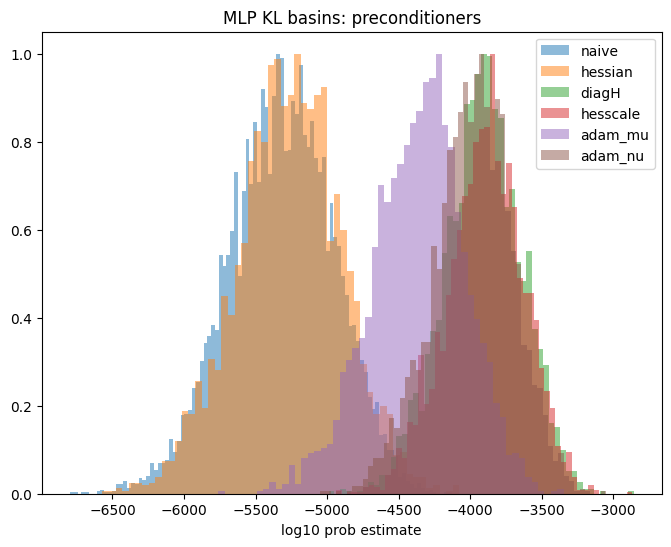

In [78]:
plt.figure(figsize=(8, 6))
settings = {'alpha': 0.5, 'fill': True}
for label, results in BEST_RESULTS.items():
    # if label in ['hessian', 'adam_mu']:
    #     continue
    these_settings = dict(settings, label=label)
    scaled_histogram(results.estimates / np.log(10), label, these_settings)
plt.xlabel("log10 prob estimate")
plt.legend()
plt.title("MLP KL basins: preconditioners")
plt.savefig(os.path.join(BASIN_VOLUME_DIR, "plots", "mlp_basins.svg"))
plt.savefig(os.path.join(BASIN_VOLUME_DIR, "plots", "mlp_basins.pdf"))
plt.show()
